# NLP Sentiment Analysis

Perform sentiment analysis using Python's NLTK (Natural Language Toolkit) library.

Use the **movie_reviews** corpus, which contains 2,000 movie reviews pre-labeled as "positive" or "negative."

In [2]:
# Import modules
import pandas as pd
import numpy as np
import string
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# # Download nltk resources, as needed
# import nltk
# nltk.download('movie_reviews')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Extract data into a dictionary of tuples
reviews_data = []
for fileid in movie_reviews.fileids():
    tag, filename = fileid.split('/')
    reviews_data.append((movie_reviews.raw(fileid), tag))

# Convert to pandas dataframe
df = pd.DataFrame(reviews_data, columns=['text', 'sentiment'])

In [3]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # tokenize text (split into individual words, usually by spaces)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english') and token not in string.punctuation] # remove stop words like "a" and "the"
    lemmatizer = WordNetLemmatizer() # reduce tokens to their base form, based on their part of speech (e.g. "jumped" -> "jump", "jumping" -> "jumping" because it is present participle
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens] # lemmatize tokens 
    processed_text = ' '.join(lemmatized_tokens) # join tokens back into a string
    return processed_text
df['text'] = df['text'].apply(preprocess_text)

In [4]:
# some ML models require numeric input, which requires a bag of words (BOW) transformation
# each obs (review text) is represented as a BOW, and each token of the obs is represented as a feature of the vector
# the value for each feature (token) is the number of times the token appears in the obs
# the BOW approach creates a WIDE, numeric representation of the corpus
# nltk vader accepts text input directly (yay!) so we can skip this step

analyzer = SentimentIntensityAnalyzer() # use nltk vader for sentiment analysis
def get_sentiment(text):
    # Use polarity_scores() to get a dictionary with four scores:
    # 'neg': The proportion of negative words in the text.
    # 'neu': The proportion of neutral words in the text.
    # 'pos': The proportion of positive words in the text.
    # 'compound': The normalized, weighted composite score, ranging from -1 (most negative) to 1 (most positive).
    scores = analyzer.polarity_scores(text)
    # Use the compound score to create a binary classification
    vader_sentiment = 1 if scores['compound'] > 0 else 0
    return vader_sentiment
df['vader_sentiment'] = df['text'].apply(get_sentiment)
df['sentiment'] = np.where(df['sentiment'] == 'pos', 1, 0)

# evaluate model performance
from sklearn.metrics import classification_report
print(classification_report(df['sentiment'], df['vader_sentiment']))

              precision    recall  f1-score   support

           0       0.70      0.40      0.51      1000
           1       0.58      0.83      0.68      1000

    accuracy                           0.61      2000
   macro avg       0.64      0.61      0.60      2000
weighted avg       0.64      0.61      0.60      2000



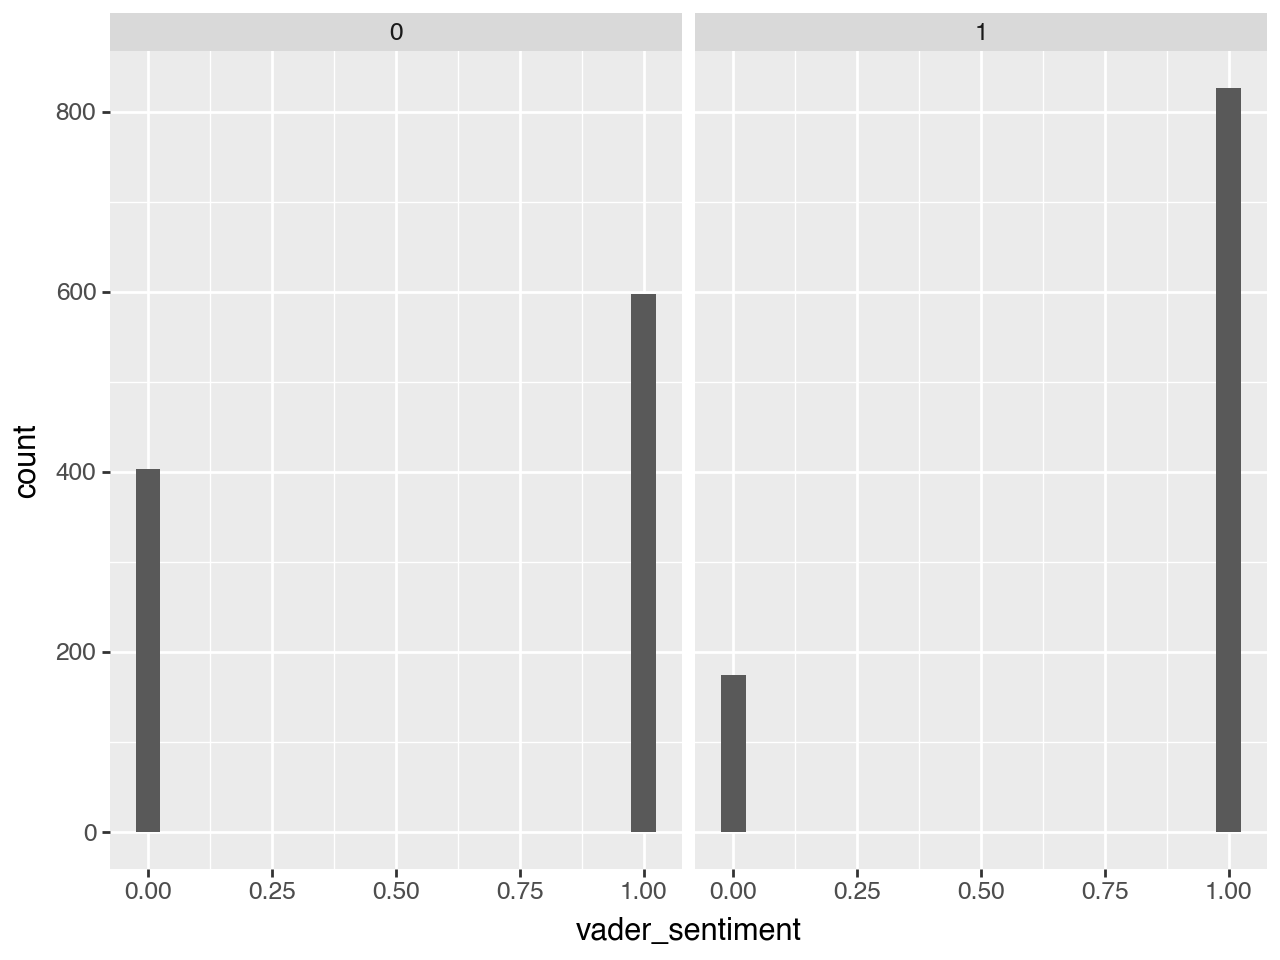

In [6]:
from plotnine import ggplot, aes, facet_wrap, geom_histogram

# Generate plot
plot = (
    ggplot(df, aes(x = 'vader_sentiment')) +
    facet_wrap(facets = 'sentiment') +
    geom_histogram(binwidth = 0.05)
)

# Display plot
plot

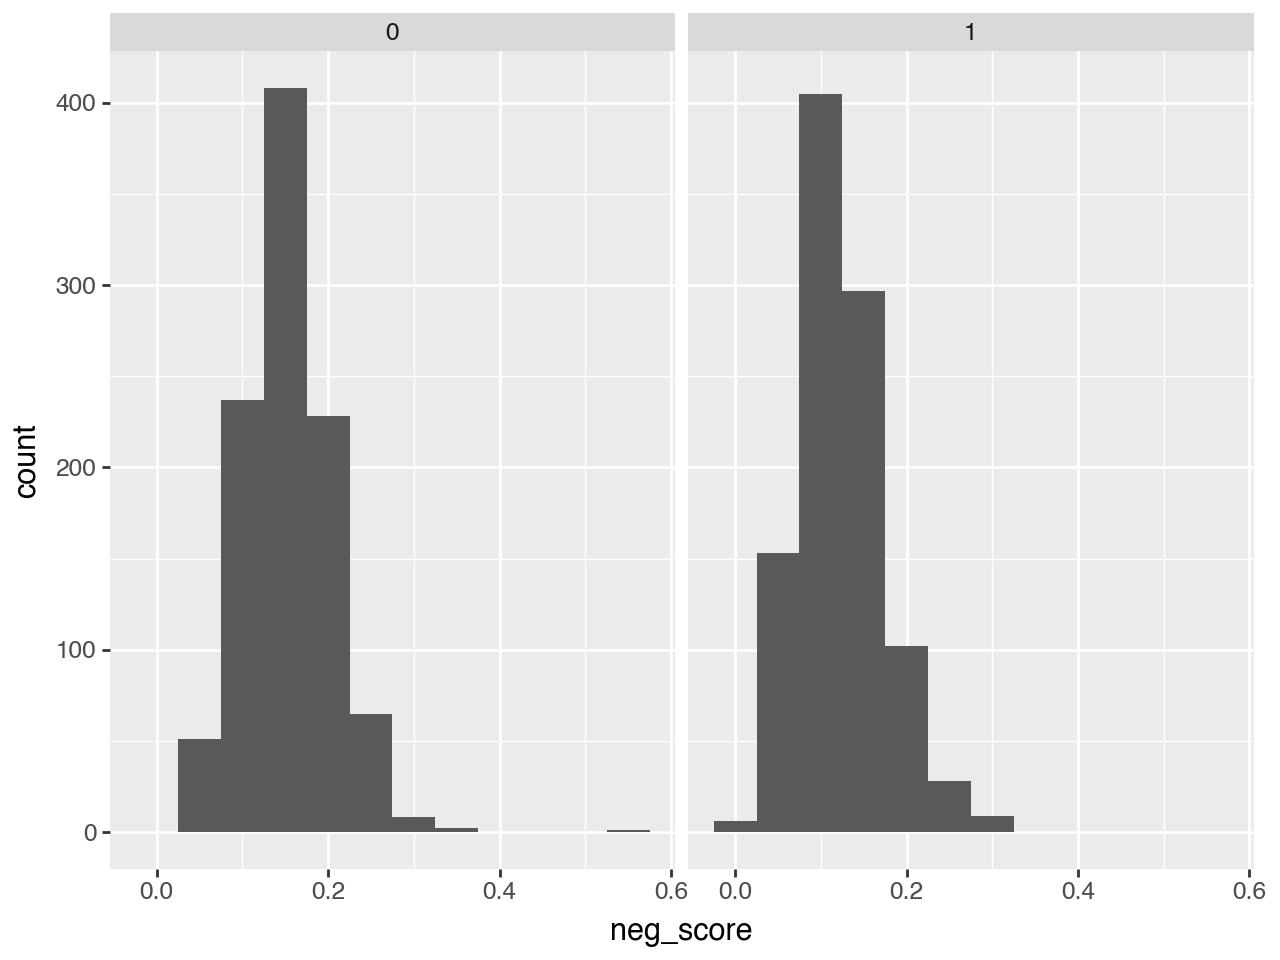

In [21]:
ggplot(df, aes(x = 'neg_score')) + \
facet_wrap(facets = "sentiment") + \
geom_histogram(binwidth = 0.05)
# negative reviews and positive reviews have similar vader neg_scores

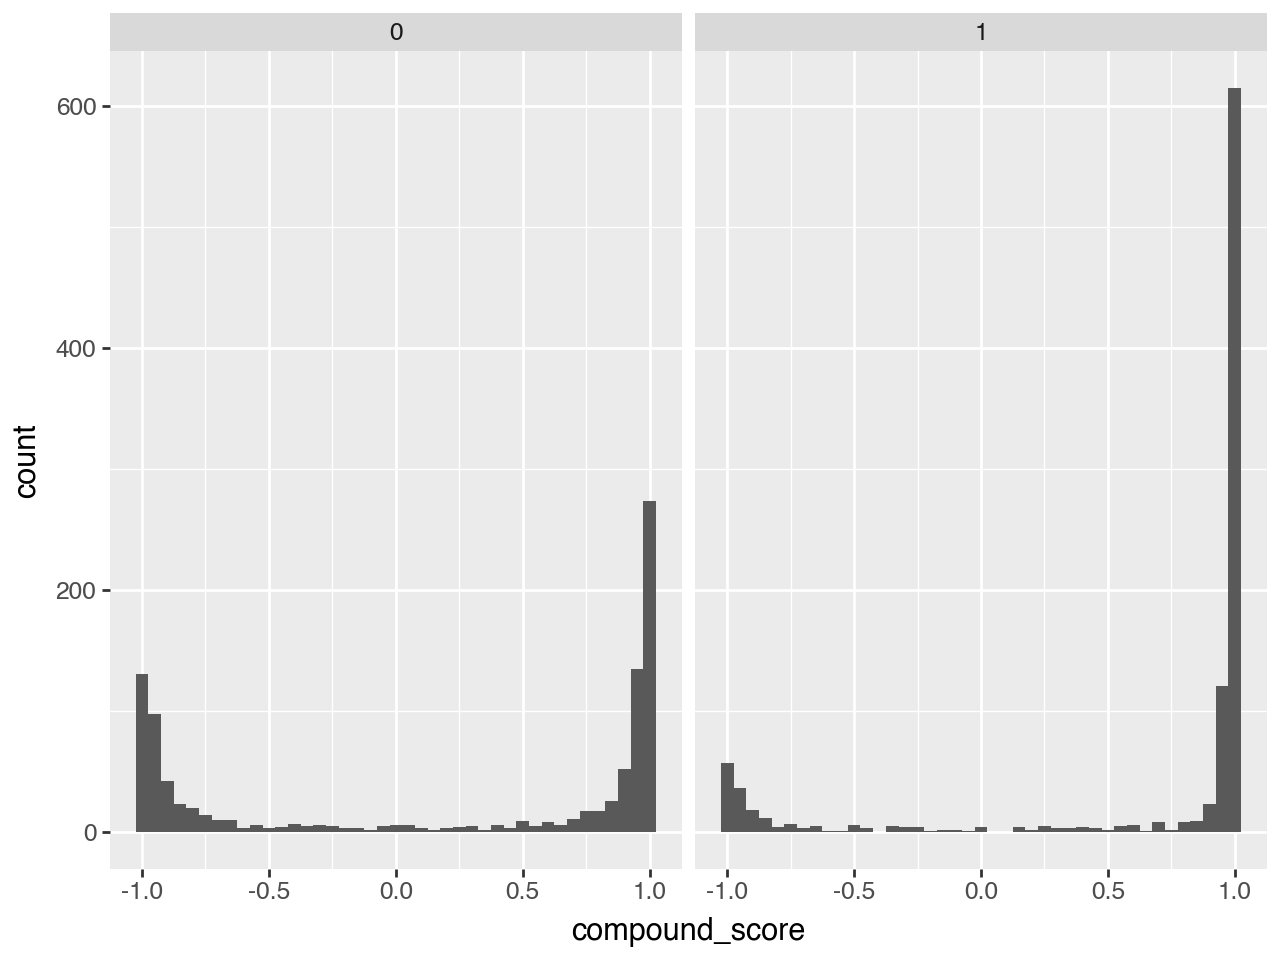

In [22]:
ggplot(df, aes(x = 'compound_score')) + \
facet_wrap(facets = "sentiment") + \
geom_histogram(binwidth = 0.05)

In [36]:
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    vader_label = 1 if scores['compound'] >= 0 and scores['pos'] >= 0 else 0
    return vader_label
df['vader_label'] = df['reviewText'].apply(get_sentiment)
from sklearn.metrics import classification_report # assess model performance
print(classification_report(df['review_label'], df['vader_label']))
# using compound score instead of pos score increased overall accuracy to 81% (2% increase)
# precision 0: for all obs classified NEG, 62% were classified correctly (minor decrease)
# precision 1: for all obs classified POS, 85% were classified correctly (minor increase)
# recall 0: for all obs that were actually NEG, 50% were classified correctly (BIG increase)
# recall 1: for all obs that were actually POS, 90% were classified correctly (minor decrease)

              precision    recall  f1-score   support

           0       0.65      0.44      0.52      4767
           1       0.84      0.93      0.88     15233

    accuracy                           0.81     20000
   macro avg       0.74      0.68      0.70     20000
weighted avg       0.79      0.81      0.80     20000

